In [207]:
import polars as pl
import polars.selectors as cs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, TargetEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV

from xgboost import XGBClassifier, train
from skopt import BayesSearchCV
import skopt.space as ss

import sys
sys.path.append("/Users/leon/Desktop/kaggle/")
import src.plotting as sp

## load data

In [154]:
df = pl.read_csv("./data/train.csv")
df.head()

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
1,0,3,"""Braund, Mr. Owen Harris""","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S"""
2,1,1,"""Cumings, Mrs. John Bradley (Fl…","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C"""
3,1,3,"""Heikkinen, Miss. Laina""","""female""",26.0,0,0,"""STON/O2. 3101282""",7.925,null,"""S"""
4,1,1,"""Futrelle, Mrs. Jacques Heath (…","""female""",35.0,1,0,"""113803""",53.1,"""C123""","""S"""
5,0,3,"""Allen, Mr. William Henry""","""male""",35.0,0,0,"""373450""",8.05,null,"""S"""


## drop columns

In [155]:
drop = [
	# "Name",
	"Ticket"
]
drop_df = (
	df.drop(drop)
	# [...]
	.select(pl.exclude("Survived"), pl.col("Survived"))
)
drop_df.head()

PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
i64,i64,str,str,f64,i64,i64,f64,str,str,i64
1,3,"""Braund, Mr. Owen Harris""","""male""",22.0,1,0,7.25,null,"""S""",0
2,1,"""Cumings, Mrs. John Bradley (Fl…","""female""",38.0,1,0,71.2833,"""C85""","""C""",1
3,3,"""Heikkinen, Miss. Laina""","""female""",26.0,0,0,7.925,null,"""S""",1
4,1,"""Futrelle, Mrs. Jacques Heath (…","""female""",35.0,1,0,53.1,"""C123""","""S""",1
5,3,"""Allen, Mr. William Henry""","""male""",35.0,0,0,8.05,null,"""S""",0


In [156]:
drop_df.select(pl.all().n_unique()).head()

PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
891,3,891,2,89,7,7,248,148,4,2


In [157]:
drop_df.describe()

statistic,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
str,f64,f64,str,str,f64,f64,f64,f64,str,str,f64
"""count""",891.0,891.0,"""891""","""891""",714.0,891.0,891.0,891.0,"""204""","""889""",891.0
"""null_count""",0.0,0.0,"""0""","""0""",177.0,0.0,0.0,0.0,"""687""","""2""",0.0
"""mean""",446.0,2.308642,null,null,29.699118,0.523008,0.381594,32.204208,null,null,0.383838
"""std""",257.353842,0.836071,null,null,14.526497,1.102743,0.806057,49.693429,null,null,0.486592
"""min""",1.0,1.0,"""Abbing, Mr. Anthony""","""female""",0.42,0.0,0.0,0.0,"""A10""","""C""",0.0
"""25%""",224.0,2.0,null,null,20.0,0.0,0.0,7.925,null,null,0.0
"""50%""",446.0,3.0,null,null,28.0,0.0,0.0,14.4542,null,null,0.0
"""75%""",669.0,3.0,null,null,38.0,1.0,0.0,31.0,null,null,1.0
"""max""",891.0,3.0,"""van Melkebeke, Mr. Philemon""","""male""",80.0,8.0,6.0,512.3292,"""T""","""S""",1.0


In [158]:
drop_df.select(pl.all().null_count())

PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,177,0,0,0,687,2,0


array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>],
       [<Axes: title={'center': 'Survived'}>, <Axes: >, <Axes: >]],
      dtype=object)

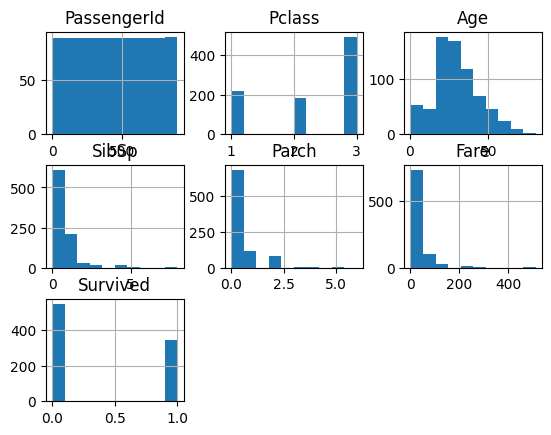

In [159]:
drop_df.to_pandas().hist()

## age column

array([[<Axes: title={'center': 'Age'}>]], dtype=object)

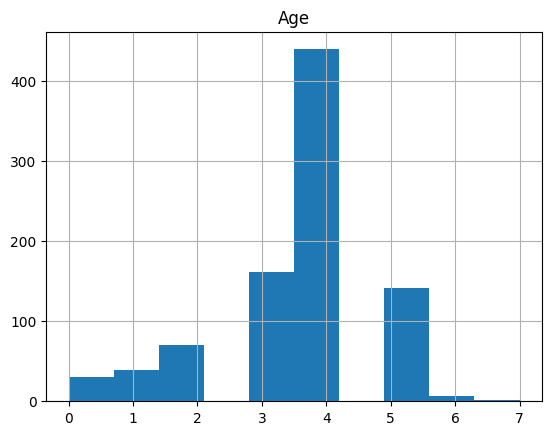

In [160]:
age_df = (
	drop_df.with_columns(pl.col("Age").fill_null(pl.col("Age").median()))
	.with_columns(pl.col("Age").cut(breaks=[3, 12, 18, 25, 40, 65, 75], labels=["baby", "child", "teenager", "young_ad", "adult", "old_ad", "senior", "very_old"]).cast(pl.Categorical))
)

age_df.select(pl.col("Age").to_physical()).to_pandas().hist()

In [161]:
age_df.head()

PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
i64,i64,str,str,cat,i64,i64,f64,str,str,i64
1,3,"""Braund, Mr. Owen Harris""","""male""","""young_ad""",1,0,7.25,null,"""S""",0
2,1,"""Cumings, Mrs. John Bradley (Fl…","""female""","""adult""",1,0,71.2833,"""C85""","""C""",1
3,3,"""Heikkinen, Miss. Laina""","""female""","""adult""",0,0,7.925,null,"""S""",1
4,1,"""Futrelle, Mrs. Jacques Heath (…","""female""","""adult""",1,0,53.1,"""C123""","""S""",1
5,3,"""Allen, Mr. William Henry""","""male""","""adult""",0,0,8.05,null,"""S""",0


In [162]:
age_df.select(pl.all().null_count())

PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,687,2,0


## simple cat cols: Pclass, Sex, Parch, Embarked

In [163]:
cat_df = (
	age_df.with_columns(
		cs.by_name(["Pclass"]).cast(pl.String).cast(pl.Categorical),
		cs.by_name(["Sex", "Embarked"]).cast(pl.Categorical)
	)
)

cat_df.head()

PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
i64,cat,str,cat,cat,i64,i64,f64,str,cat,i64
1,"""3""","""Braund, Mr. Owen Harris""","""male""","""young_ad""",1,0,7.25,null,"""S""",0
2,"""1""","""Cumings, Mrs. John Bradley (Fl…","""female""","""adult""",1,0,71.2833,"""C85""","""C""",1
3,"""3""","""Heikkinen, Miss. Laina""","""female""","""adult""",0,0,7.925,null,"""S""",1
4,"""1""","""Futrelle, Mrs. Jacques Heath (…","""female""","""adult""",1,0,53.1,"""C123""","""S""",1
5,"""3""","""Allen, Mr. William Henry""","""male""","""adult""",0,0,8.05,null,"""S""",0


## fare col

array([[<Axes: title={'center': 'Fare'}>]], dtype=object)

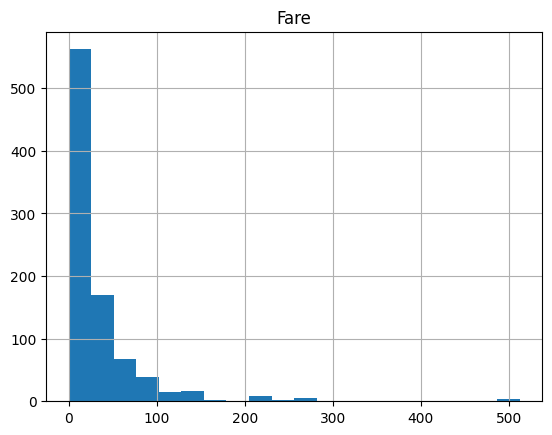

In [164]:
cat_df.select(cs.by_name(["Fare"])).to_pandas().hist(bins=20)

In [165]:
fare_df = (
	cat_df.with_columns(
		pl.col("Fare").qcut(10)
	)
)

fare_df.head()

PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
i64,cat,str,cat,cat,i64,i64,cat,str,cat,i64
1,"""3""","""Braund, Mr. Owen Harris""","""male""","""young_ad""",1,0,"""(-inf, 7.55]""",null,"""S""",0
2,"""1""","""Cumings, Mrs. John Bradley (Fl…","""female""","""adult""",1,0,"""(39.6875, 77.9583]""","""C85""","""C""",1
3,"""3""","""Heikkinen, Miss. Laina""","""female""","""adult""",0,0,"""(7.8542, 8.05]""",null,"""S""",1
4,"""1""","""Futrelle, Mrs. Jacques Heath (…","""female""","""adult""",1,0,"""(39.6875, 77.9583]""","""C123""","""S""",1
5,"""3""","""Allen, Mr. William Henry""","""male""","""adult""",0,0,"""(7.8542, 8.05]""",null,"""S""",0


## cabin col

In [166]:
cabin_df = (
	fare_df.with_columns(
		pl.col("Cabin").str.slice(0, 1).cast(pl.Categorical).alias("Deck"),
	).drop(["Cabin"])
)

cabin_df.head()

PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,Deck
i64,cat,str,cat,cat,i64,i64,cat,cat,i64,cat
1,"""3""","""Braund, Mr. Owen Harris""","""male""","""young_ad""",1,0,"""(-inf, 7.55]""","""S""",0,null
2,"""1""","""Cumings, Mrs. John Bradley (Fl…","""female""","""adult""",1,0,"""(39.6875, 77.9583]""","""C""",1,"""C"""
3,"""3""","""Heikkinen, Miss. Laina""","""female""","""adult""",0,0,"""(7.8542, 8.05]""","""S""",1,null
4,"""1""","""Futrelle, Mrs. Jacques Heath (…","""female""","""adult""",1,0,"""(39.6875, 77.9583]""","""S""",1,"""C"""
5,"""3""","""Allen, Mr. William Henry""","""male""","""adult""",0,0,"""(7.8542, 8.05]""","""S""",0,null


/var/folders/h6/c2yy64s57ks3xp5rvf8z16t00000gn/T/ipykernel_46328/2458427456.py:5: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  cabin_df.select(cs.by_name(["Deck"]).fill_null("0")).to_numpy().flatten(),


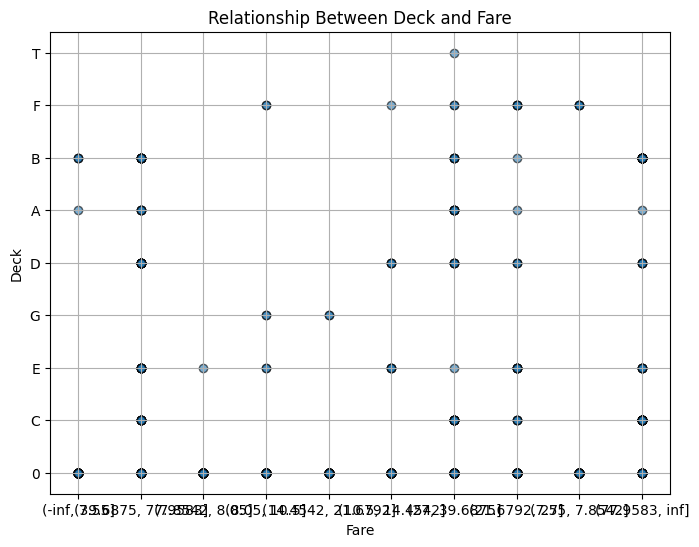

In [167]:
cabin_df.select(cs.by_name(["Fare", "Deck"]))
plt.figure(figsize=(8, 6))
plt.scatter(
	cabin_df.select(cs.by_name(["Fare"])).to_numpy().flatten(),
	cabin_df.select(cs.by_name(["Deck"]).fill_null("0")).to_numpy().flatten(),
	alpha=0.6, edgecolors="k")
plt.xlabel("Fare")
plt.ylabel("Deck")
plt.title("Relationship Between Deck and Fare")
plt.grid(True)
plt.show()

In [168]:
cabin_df.head()

PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,Deck
i64,cat,str,cat,cat,i64,i64,cat,cat,i64,cat
1,"""3""","""Braund, Mr. Owen Harris""","""male""","""young_ad""",1,0,"""(-inf, 7.55]""","""S""",0,null
2,"""1""","""Cumings, Mrs. John Bradley (Fl…","""female""","""adult""",1,0,"""(39.6875, 77.9583]""","""C""",1,"""C"""
3,"""3""","""Heikkinen, Miss. Laina""","""female""","""adult""",0,0,"""(7.8542, 8.05]""","""S""",1,null
4,"""1""","""Futrelle, Mrs. Jacques Heath (…","""female""","""adult""",1,0,"""(39.6875, 77.9583]""","""S""",1,"""C"""
5,"""3""","""Allen, Mr. William Henry""","""male""","""adult""",0,0,"""(7.8542, 8.05]""","""S""",0,null


In [169]:
data = (
	cabin_df.select(
		cs.by_name(["Fare", "Deck"])
		.to_physical()
	).drop_nulls()
).to_numpy()

targ = (
	cabin_df.filter(pl.col("Deck").is_null())
	.select(
		cs.by_name(["Fare"])
		.to_physical()
	)
).to_numpy()
X = data[:, :-1]
y = data[:, -1]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

ppl = Pipeline([
	# ("enc", TargetEncoder()),
	("clf", XGBClassifier())
]).fit(X, y_encoded)

res = ppl.predict(targ)

ser = (
	cabin_df.select(
		cs.by_name(["Fare", "Deck"])
		.to_physical()
	)
).to_numpy()[:, -1].tolist()

# Replace `None` values in `ser` with corresponding values from `res`
res_index = 0  # Index to track elements in `res`
for i in range(len(ser)):
	if ser[i] is None:  # Check if the value in `ser` is None
		ser[i] = res[res_index]  # Replace with the corresponding value from `res`
		res_index += 1  # Move to the next element in `res`

# Convert `ser` back to a NumPy array if needed
ser = np.array(ser)
cabin_df = (
	cabin_df.with_columns(
		pl.Series(values=ser).cast(pl.String).cast(pl.Categorical).alias("Deck")
	)
)

cabin_df.head()

PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,Deck
i64,cat,str,cat,cat,i64,i64,cat,cat,i64,cat
1,"""3""","""Braund, Mr. Owen Harris""","""male""","""young_ad""",1,0,"""(-inf, 7.55]""","""S""",0,"""NaN"""
2,"""1""","""Cumings, Mrs. John Bradley (Fl…","""female""","""adult""",1,0,"""(39.6875, 77.9583]""","""C""",1,"""0.0"""
3,"""3""","""Heikkinen, Miss. Laina""","""female""","""adult""",0,0,"""(7.8542, 8.05]""","""S""",1,"""NaN"""
4,"""1""","""Futrelle, Mrs. Jacques Heath (…","""female""","""adult""",1,0,"""(39.6875, 77.9583]""","""S""",1,"""0.0"""
5,"""3""","""Allen, Mr. William Henry""","""male""","""adult""",0,0,"""(7.8542, 8.05]""","""S""",0,"""NaN"""


## Sibsp & Parch

array([[<Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>]], dtype=object)

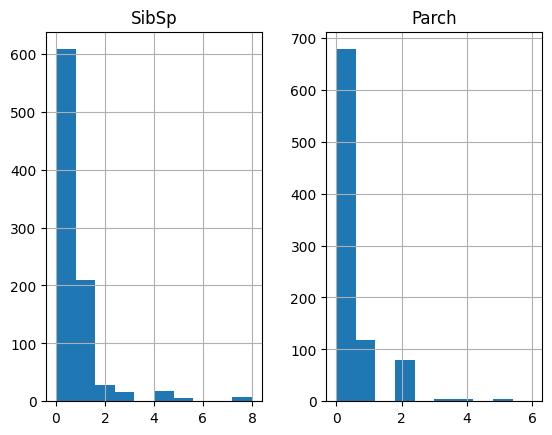

In [170]:
df.select(cs.by_name(["SibSp", "Parch"])).to_pandas().hist()

In [171]:
group_df = (
	cabin_df.with_columns((pl.col("SibSp") + pl.col("Parch")).alias("GroupSize"))
	.with_columns(pl.col("GroupSize").cut(breaks=[1, 2, 5], labels=["alone", "couple", "small_group", "big_group"]))
	.drop(["SibSp", "Parch"])
)

group_df.head()

PassengerId,Pclass,Name,Sex,Age,Fare,Embarked,Survived,Deck,GroupSize
i64,cat,str,cat,cat,cat,cat,i64,cat,cat
1,"""3""","""Braund, Mr. Owen Harris""","""male""","""young_ad""","""(-inf, 7.55]""","""S""",0,"""NaN""","""alone"""
2,"""1""","""Cumings, Mrs. John Bradley (Fl…","""female""","""adult""","""(39.6875, 77.9583]""","""C""",1,"""0.0""","""alone"""
3,"""3""","""Heikkinen, Miss. Laina""","""female""","""adult""","""(7.8542, 8.05]""","""S""",1,"""NaN""","""alone"""
4,"""1""","""Futrelle, Mrs. Jacques Heath (…","""female""","""adult""","""(39.6875, 77.9583]""","""S""",1,"""0.0""","""alone"""
5,"""3""","""Allen, Mr. William Henry""","""male""","""adult""","""(7.8542, 8.05]""","""S""",0,"""NaN""","""alone"""


## marital status col

In [172]:
marital_df = (
	group_df.with_columns(
		pl.when(pl.col("Name").str.contains_any(["Mr.", "Ms."])).then(pl.lit("unknown"))
		.when(pl.col("Name").str.contains("Mrs.")).then(pl.lit("married"))
		.when(pl.col("Name").str.contains("Miss.")).then(pl.lit("unmarried"))
		.otherwise(pl.lit("unknown"))
		.cast(pl.Categorical).alias("MaritalStatus")
	)
)

## royalty col

In [173]:
titles = [
	"Sir", "Dame", "Knight",
	"King", "Queen", "Prince", "Princess",
	"Duke", "Duchess", "Marquess", "Marchioness",
	"Earl", "Count", "Countess",
	"Viscount", "Viscountess", "Baron", "Baroness",
	"His Majesty", "Her Majesty", "His Royal Highness", "Her Royal Highness",
	"His Grace", "Her Grace", "Lord", "Lady"
]

royalty_df = (
	marital_df.with_columns(
		pl.when(pl.col("Name").str.contains_any(titles)).then(pl.lit("royal"))
		.otherwise(pl.lit("commoner"))
		.cast(pl.Categorical).alias("Royal")
	).drop(["Name"])
)

## full data

In [218]:
final_df = (
	royalty_df.select(
		pl.exclude(["PassengerId", "Survived"]),
		pl.col("Survived")
	)
)

pipe = Pipeline([
	("encoder", OneHotEncoder(sparse_output=False)),
	("pca", PCA(n_components=0.99))
])

X = pipe.fit_transform(final_df.select(pl.exclude("Survived")).to_pandas())
y = data[:, -1]

sss = StratifiedShuffleSplit(n_splits=1, random_state=42)
for train_idx, test_idx in sss.split(X, y):
	X_train, y_train = X[train_idx], y[train_idx]
	X_test, y_test = X[test_idx], y[test_idx]


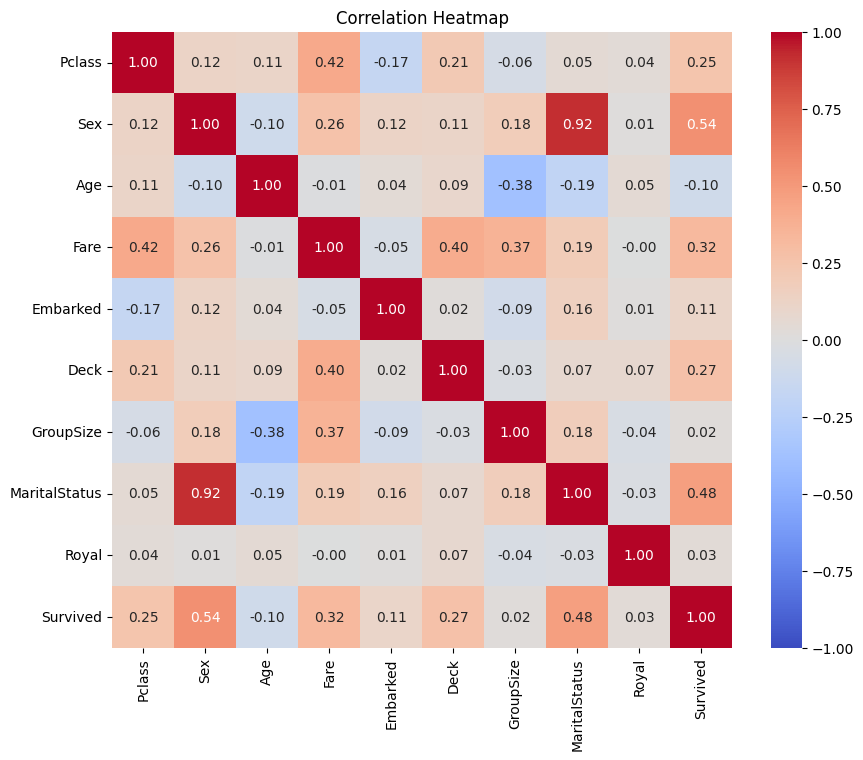

In [216]:
cm = final_df.select(pl.all().to_physical()).to_pandas().corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, cbar=True)
plt.title("Correlation Heatmap")
plt.show()

In [220]:
simple_m = XGBClassifier(
	**{
		'colsample_bytree': 0.8,
		'learning_rate': 0.01,
		'max_depth': 4,
		'n_estimators': 300,
		'subsample': 0.8
	}
).fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])
simple_m.score(X_test, y_test)

[0]	validation_0-logloss:0.66181	validation_1-logloss:0.66593
[1]	validation_0-logloss:0.65692	validation_1-logloss:0.66243
[2]	validation_0-logloss:0.65211	validation_1-logloss:0.65908
[3]	validation_0-logloss:0.64829	validation_1-logloss:0.65720
[4]	validation_0-logloss:0.64352	validation_1-logloss:0.65391
[5]	validation_0-logloss:0.63901	validation_1-logloss:0.65093
[6]	validation_0-logloss:0.63541	validation_1-logloss:0.64831
[7]	validation_0-logloss:0.63086	validation_1-logloss:0.64496
[8]	validation_0-logloss:0.62659	validation_1-logloss:0.64193
[9]	validation_0-logloss:0.62243	validation_1-logloss:0.63974
[10]	validation_0-logloss:0.61831	validation_1-logloss:0.63685
[11]	validation_0-logloss:0.61418	validation_1-logloss:0.63410
[12]	validation_0-logloss:0.61125	validation_1-logloss:0.63258
[13]	validation_0-logloss:0.60826	validation_1-logloss:0.63129
[14]	validation_0-logloss:0.60502	validation_1-logloss:0.62958
[15]	validation_0-logloss:0.60104	validation_1-logloss:0.62738
[1

0.7888888888888889

In [221]:
fit_params = {
	"eval_set": [(X_train, y_train), (X_test, y_test)],
	"verbose": False
}

param_grid = {
	"n_estimators": [250, 300, 350],
	"max_depth": [2, 3, 4],
	"learning_rate": [0.01, 0.1],
	"subsample": [0.7, 0.8],
	"colsample_bytree": [0.8, 0.9],
}

opt = GridSearchCV(
	XGBClassifier(),
	param_grid,
	cv=2
).fit(X_train, y_train, **fit_params)

opt.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 250,
 'subsample': 0.7}

In [225]:
opt.best_estimator_.score(X_test, y_test)

0.7555555555555555

/Users/leon/Desktop/kaggle/src/plotting.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


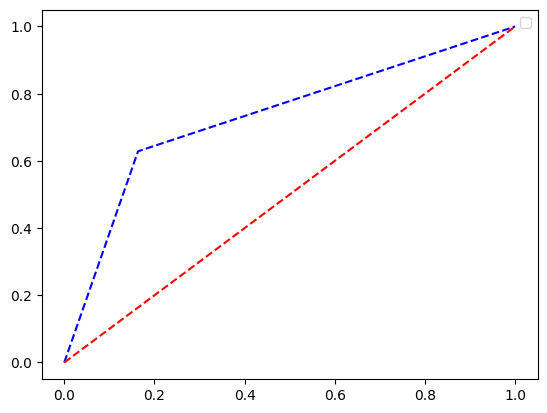

In [224]:
y_pred = opt.best_estimator_.predict(X_test)
sp.MetricPlots().gen_and_plot_roc_curve(y_test, y_pred)